## Wrangle Data with Spark's SQL API

This notebook will use Spark in local mode to demonstarate spark's SQL API for Data Wrangling. I will use a dataset provided by Udacity, which can be found in the free Spark course. It contains the log data from the fictional music streaming service 'sparkify'

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import sum as Fsum

import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# initiate a Spark Session to have access to the top level SQL API 
spark = SparkSession \
    .builder \
    .appName("Data wrangling with Spark SQL") \
    .getOrCreate()

In [10]:
log_data = spark.read.json('sparkify_log_small.json')

In [11]:
log_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Create a View And Run Queries

To run SQL queries we need to creat a temporate view of the DataFrame

In [12]:
log_data.createOrReplaceTempView('log_data_table')

In [14]:
# how many rows are in the table
spark.sql('''
        SELECT COUNT(*)
        FROM log_data_table
''').show()

+--------+
|count(1)|
+--------+
|   10000|
+--------+



In [16]:
# show the first row of data
spark.sql('''
        SELECT *
        FROM log_data_table
        LIMIT 1
''').show()

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------

In [18]:
# show the different pages 
spark.sql('''
        SELECT DISTINCT(page)
        FROM log_data_table
        ORDER BY page ASC
''').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



#### Get datetime from timestamp
to get the datetime from a SQL query, we can use UDFs, which we have to register

In [35]:
spark.udf.register('get_hour', lambda x: int(dt.datetime.fromtimestamp(x / 1000.0).hour))
spark.udf.register('get_day_of_week', lambda x: dt.datetime.fromtimestamp(x / 1000.0).strftime('%a'))

<function __main__.<lambda>(x)>

In [43]:
songs_per_hour = spark.sql('''
                    SELECT get_hour(ts) AS hour, COUNT(*) AS plays_per_hour
                    FROM log_data_table
                    WHERE page = 'NextSong'
                    GROUP BY hour
                    ORDER BY cast(hour as int) ASC
''')

In [44]:
songs_per_day = spark.sql('''
                    SELECT get_day_of_week(ts) AS day, COUNT(*) AS plays_per_hour
                    FROM log_data_table
                    WHERE page = 'NextSong'
                    GROUP BY day
''')

In [45]:
songs_per_hour.show()

+----+--------------+
|hour|plays_per_hour|
+----+--------------+
|   0|           375|
|   1|           456|
|   2|           454|
|   3|           382|
|   4|           302|
|   5|           352|
|   6|           276|
|   7|           348|
|   8|           358|
|   9|           375|
|  10|           249|
|  11|           216|
|  12|           228|
|  13|           251|
|  14|           339|
|  15|           462|
|  16|           479|
|  17|           484|
|  18|           430|
|  19|           362|
+----+--------------+
only showing top 20 rows



In [38]:
songs_per_day.show()

+---+--------------+
|day|plays_per_hour|
+---+--------------+
|Thu|          2071|
|Wed|          6071|
|Tue|           205|
+---+--------------+



In [46]:
# transfrom outout to pandas DataFrame to visualize it
pd_songs_per_hour = songs_per_hour.toPandas()
pd_songs_per_day = songs_per_day.toPandas()

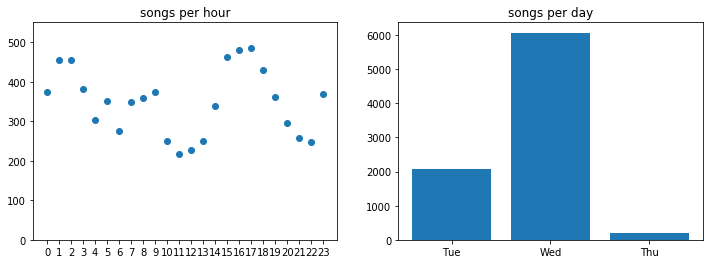

In [49]:
day_order = ['Tue', 'Wed', 'Thu']

plt.subplots(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(pd_songs_per_hour['hour'], pd_songs_per_hour['plays_per_hour'])
plt.ylim(0, 550)
plt.title('songs per hour')

plt.subplot(1,2,2)
plt.bar(pd_songs_per_day['day'], pd_songs_per_day['plays_per_hour'])
plt.xticks(range(3), day_order)
plt.title('songs per day');

### Questions
1. Which page did user id "" (empty string) NOT visit?
2. Why might you prefer to use SQL over data frames? Why might you prefer data frames over SQL?
3. How many female users do we have in the data set?
4. How many songs were played from the most played artist?

#### 1. Which page did user id "" (empty string) NOT visit?

In [57]:
# full outer join
spark.sql('''
    SELECT *
    FROM (
        SELECT DISTINCT page
        FROM log_data_table
        WHERE userId = '') as user_pages
    FULL OUTER JOIN (
        SELECT DISTINCT page
        FROM log_data_table) as all_pages
    ON user_pages.page = all_pages.page
''').show()

+-----+----------------+
| page|            page|
+-----+----------------+
| null|Submit Downgrade|
| Home|            Home|
| null|       Downgrade|
| null|          Logout|
| null|   Save Settings|
|About|           About|
| null|        Settings|
|Login|           Login|
| null|        NextSong|
| Help|            Help|
| null|         Upgrade|
| null|           Error|
| null|  Submit Upgrade|
+-----+----------------+



In [61]:
# right join 
spark.sql('''
    SELECT *
    FROM (
        SELECT DISTINCT page
        FROM log_data_table
        WHERE userId = '') as user_pages
    RIGHT JOIN (
        SELECT DISTINCT page
        FROM log_data_table) as all_pages
    ON user_pages.page = all_pages.page
    WHERE user_pages.page IS NULL
''').show()

+----+----------------+
|page|            page|
+----+----------------+
|null|Submit Downgrade|
|null|       Downgrade|
|null|          Logout|
|null|   Save Settings|
|null|        Settings|
|null|        NextSong|
|null|         Upgrade|
|null|           Error|
|null|  Submit Upgrade|
+----+----------------+



#### 2. Why might you prefer to use SQL over data frames? Why might you prefer data frames over SQL?
Both Spark SQL and Spark Data Frames are part of the Spark SQL library. Hence, they both use the Spark SQL Catalyst Optimizer to optimize queries. 

You might prefer SQL over data frames because the syntax is clearer especially for teams already experienced in SQL.

Spark data frames give you more control. You can break down your queries into smaller steps, which can make debugging easier. You can also [cache](https://unraveldata.com/to-cache-or-not-to-cache/) intermediate results or [repartition](https://hackernoon.com/managing-spark-partitions-with-coalesce-and-repartition-4050c57ad5c4) intermediate results.

#### 3. How many female users do we have in the data set?

In [71]:
spark.sql('''
    SELECT COUNT(DISTINCT userId) AS females
    FROM log_data_table
    WHERE gender = 'F'
''').show()

+-------+
|females|
+-------+
|    462|
+-------+



#### 4. How many songs were played from the most played artist?

In [81]:
spark.sql('''
    SELECT artist, COUNT(artist) AS number_of_plays
    FROM log_data_table
    WHERE page = 'NextSong'
    GROUP BY artist
    ORDER BY number_of_plays DESC
    LIMIT 1
''').show()

+--------+---------------+
|  artist|number_of_plays|
+--------+---------------+
|Coldplay|             83|
+--------+---------------+

